<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/BitcoinFeatures_Wavenet_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chargement des données

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

On télécharge un script depuis Github permettant de télécharger un fichier stocké sur GoogleDrive, puis on utilise ce script écrit en Python pour télécharger le fichier `bitcoin.zip`. Enfin, on décompresse les données pour obtenir le fichier `bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv` :

In [2]:
# Récupération des données au format .csv
!rm *.csv
!wget --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/LorenzMap.csv"

rm: cannot remove '*.csv': No such file or directory
--2021-04-27 16:46:48--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/LorenzMap.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34567 (34K) [text/plain]
Saving to: ‘LorenzMap.csv’

LorenzMap.csv       100%[===================>]  33.76K  --.-KB/s    in 0.002s  

2021-04-27 16:46:48 (13.7 MB/s) - ‘LorenzMap.csv’ saved [34567/34567]



Charge la série sous Pandas et affiche les informations du fichier :

In [3]:
# Création de la série sous Pandas
serie = pd.read_csv("LorenzMap.csv", names=['X','Y','Z'])
serie

,X,Y,Z
0,0.000000,1.00000,1.0500
1,0.048931,0.99832,1.0362
2,0.095542,1.00310,1.0227
3,0.140250,1.01400,1.0097
4,0.183460,1.03090,0.9971
...,...,...,...
1552,1.282300,-1.93910,25.2700
1553,0.901650,-1.87140,24.4010
1554,0.574140,-1.81070,23.5710
1555,0.292540,-1.76190,22.7750


# Pré-traitement des données

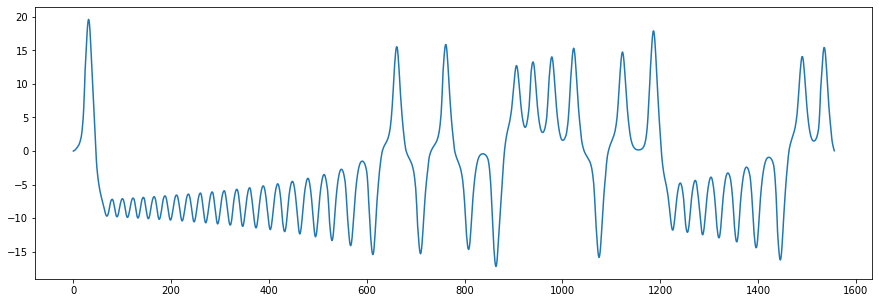

In [4]:
# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(serie.index, serie['X'])

# Préparation des données

In [5]:
# Définition des dates de début et de fin

temps_debut = 0
temps_fin = 1500

serie_etude = serie.loc[temps_debut:temps_fin].copy()
serie_etude

,X,Y,Z
0,0.000000,1.00000,1.0500
1,0.048931,0.99832,1.0362
2,0.095542,1.00310,1.0227
3,0.140250,1.01400,1.0097
4,0.183460,1.03090,0.9971
...,...,...,...
1496,10.584000,3.81220,36.1470
1497,9.564800,2.61540,35.2170
1498,8.540200,1.68650,34.1340
1499,7.547100,1.00680,32.9660


# Prépartion des datasets multivariés

In [6]:
serie_etude

,X,Y,Z
0,0.000000,1.00000,1.0500
1,0.048931,0.99832,1.0362
2,0.095542,1.00310,1.0227
3,0.140250,1.01400,1.0097
4,0.183460,1.03090,0.9971
...,...,...,...
1496,10.584000,3.81220,36.1470
1497,9.564800,2.61540,35.2170
1498,8.540200,1.68650,34.1340
1499,7.547100,1.00680,32.9660


**1. Séparation des données en données pour l'entrainement et la validation**

On réserve 20% des données pour l'entrainement et le reste pour la validation :

In [7]:
# Sépare les données en entrainement et tests
pourcentage = 0.7
temps_separation = int(len(serie_etude) * pourcentage)
date_separation = serie_etude.index[temps_separation]

serie_entrainement = []
serie_test = []

serie_entrainement.append(serie_etude['X'].iloc[:temps_separation])
serie_test.append(serie_etude['X'].iloc[temps_separation:])

serie_entrainement.append(serie_etude['Y'].iloc[:temps_separation])
serie_test.append(serie_etude['Y'].iloc[temps_separation:])

serie_entrainement.append(serie_etude['Z'].iloc[:temps_separation])
serie_test.append(serie_etude['Z'].iloc[temps_separation:])

print("Taille de l'entrainement : %d" %len(serie_entrainement[0]))
print("Taille de la validation : %d" %len(serie_test[0]))

Taille de l'entrainement : 1050
Taille de la validation : 451


On normalise les données :

In [8]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(np.asarray(serie_entrainement))
std = tf.math.reduce_std(np.asarray((serie_entrainement)))

# Normalisation des données
serie_entrainement = (serie_entrainement-mean)/std
serie_test = (serie_test-mean)/std

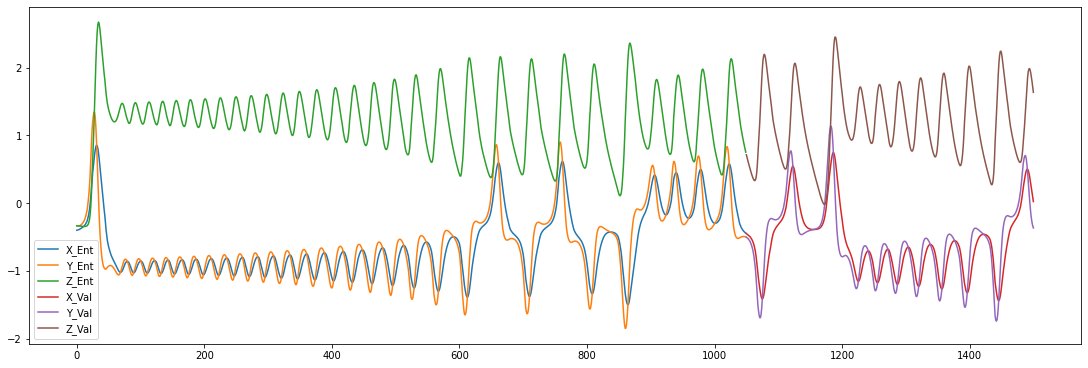

In [9]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(serie_etude.index[:temps_separation].values,serie_entrainement[0], label="X_Ent")
ax.plot(serie_etude.index[:temps_separation].values,serie_entrainement[1], label="Y_Ent")
ax.plot(serie_etude.index[:temps_separation].values,serie_entrainement[2], label="Z_Ent")

ax.plot(serie_etude.index[temps_separation:].values,serie_test[0], label="X_Val")
ax.plot(serie_etude.index[temps_separation:].values,serie_test[1], label="Y_Val")
ax.plot(serie_etude.index[temps_separation:].values,serie_test[2], label="Z_Val")


ax.legend()
plt.show()

**2. Création des datasets**

In [10]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(series, taille_fenetre, horizon, batch_size):
  serie_concat = tf.expand_dims(series[0],1)

  for i in range(1,len(series)):
    serie_ = tf.expand_dims(series[i],1)
    serie_concat = tf.concat([serie_concat,serie_],1)

  dataset = tf.data.Dataset.from_tensor_slices(serie_concat)
  dataset = dataset.window(taille_fenetre+horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + horizon))
  dataset = dataset.map(lambda x: (x[0:taille_fenetre],tf.expand_dims(x[-taille_fenetre:][:,0],1)))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [11]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 16
horizon = 1
batch_size = 64

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement,taille_fenetre,horizon,batch_size)
dataset_val = prepare_dataset_XY(serie_test,taille_fenetre,horizon,batch_size)

In [12]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

16
(64, 16, 3)
(64, 16, 1)


In [13]:
for element in dataset.take(1):
  print(element)


(<tf.Tensor: shape=(64, 16, 3), dtype=float64, numpy=
array([[[-0.39977373, -0.33569354, -0.33248953],
        [-0.39663822, -0.33580119, -0.33337384],
        [-0.39365138, -0.33549489, -0.33423892],
        ...,
        [-0.31992341, -0.22381594, -0.34390734],
        [-0.30510807, -0.19289085, -0.34235275],
        [-0.28778079, -0.15628824, -0.33942813]],

       [[-0.39663822, -0.33580119, -0.33337384],
        [-0.39365138, -0.33549489, -0.33423892],
        [-0.39078648, -0.33479642, -0.33507196],
        ...,
        [-0.30510807, -0.19289085, -0.34235275],
        [-0.28778079, -0.15628824, -0.33942813],
        [-0.26746096, -0.11311102, -0.33461699]],

       [[-0.39365138, -0.33549489, -0.33423892],
        [-0.39078648, -0.33479642, -0.33507196],
        [-0.38801758, -0.33371346, -0.33587937],
        ...,
        [-0.28778079, -0.15628824, -0.33942813],
        [-0.26746096, -0.11311102, -0.33461699],
        [-0.23571563, -0.04558332, -0.32434494]],

       ...,

      

On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [14]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # #56x((1000,16,5),(1000,16,5)) => x = 56x(1000,16,5) ; y = 56x(1000,16,5)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 56x(1000,16,5) => (56,1000,16,5)
y = np.asarray(y,dtype=np.float32)      # 56x(1000,16,5) => (56,1000,16,5)

x_train = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],taille_fenetre,x.shape[3])))     # (56,1000,16,5) => (56*1000,16,5)
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],taille_fenetre,y.shape[3])))     # (56,1000,16,5) => (56*1000,16,5)

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(1024, 16, 3)
(1024, 16, 1)


Puis la même chose pour les données de validation :

In [15]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # #56x((1000,16,5),(1000,16,1)) => x = 56x(1000,16,5) ; y = 56x(1000,16,1)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 56x(1000,16,5) => (56,1000,16,5)
y = np.asarray(y,dtype=np.float32)      # 56x(1000,16,1) => (56,1000,16,1)

x_val = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],taille_fenetre,x.shape[3])))     # (56,1000,16,5) => (56*1000,16,5)
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],taille_fenetre,y.shape[3])))     # (56,1000,16,1) => (56*1000,16,1)

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(384, 16, 3)
(384, 16, 1)


# Création du modèle type Wavenet Multivarié - Apprentissage univarié

**1. Création du réseau**

In [16]:
from keras.layers import Conv1D
from keras.layers import Conv1D
from keras.utils.conv_utils import conv_output_length
from keras import layers
from keras.regularizers import l2
import keras.backend as K
from keras.engine import Input
from keras.engine import Model

In [17]:
class CausalDilatedConv1D(Conv1D):
    def __init__(self, nb_filter, filter_length, init='glorot_uniform', activation=None, weights=None,
                 border_mode='valid', subsample_length=1, atrous_rate=1, W_regularizer=None, b_regularizer=None,
                 activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True, causal=False, **kwargs):
        super(CausalDilatedConv1D, self).__init__(nb_filter, filter_length, weights=weights, activation=activation, 
                padding=border_mode, strides=subsample_length, dilation_rate=atrous_rate, kernel_regularizer=W_regularizer, 
                bias_regularizer=b_regularizer, activity_regularizer=activity_regularizer, kernel_constraint=W_constraint, 
                bias_constraint=b_constraint, use_bias=bias, **kwargs)
        self.causal = causal
        self.nb_filter = nb_filter
        self.atrous_rate = atrous_rate
        self.filter_length = filter_length
        self.subsample_length = subsample_length
        self.border_mode = border_mode
        if self.causal and border_mode != 'valid':
            raise ValueError("Causal mode dictates border_mode=valid.")

    def compute_output_shape(self, input_shape):
        input_length = input_shape[1]
        if self.causal:
            input_length += self.atrous_rate * (self.filter_length - 1)
        length = conv_output_length(input_length, self.filter_length, self.border_mode, self.strides[0], dilation=self.atrous_rate)
        return (input_shape[0], length, self.nb_filter)

    def call(self, x, mask=None):
        if self.causal:
            x = K.temporal_padding(x, padding=(self.atrous_rate * (self.filter_length - 1), 0))
        # return super(CausalAtrousConvolution1D, self).call(x, mask)
        return super(CausalDilatedConv1D, self).call(x)

In [18]:
def _compute_receptive_field(dilation_depth, stacks):
  return stacks * (2 ** dilation_depth * 2) - (stacks - 1)

In [34]:
def build_model_residual_block(x, i, s,nb_filters, dim_filters, use_bias,res_l2):
        original_x = x
        relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=2 ** i, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_relu_s%d' % (2 ** i, s), activation='relu', W_regularizer=l2(res_l2))(x)
        res_x = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_x = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        res_x = layers.Add()([original_x, res_x])
        return res_x, skip_x

def build_model_couche_condition(x, nb_input_bins, nb_filters, dim_filters, use_bias,res_l2):
        original_x = x
        skip_conditions = []

        relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,1, 0), activation='relu',
                                       W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,0],2))

        skip_ = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_conditions.append(skip_)

        for i in range(1,nb_input_bins):
          relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,i+1,0), activation='relu',
                                                    W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,i],2))

          skip_ = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
          skip_conditions.append(skip_)

        out = layers.Add()(skip_conditions)
        return out


def build_model(fragment_length, nb_filters, dim_filters, nb_input_bins, dilation_depth, stacks, use_bias, res_l2, final_l2):
        input_shape = Input(shape=(fragment_length, nb_input_bins), name='input_part')
        out = input_shape

        for s in range(stacks):
            if nb_input_bins > 1 :
                # Couche conditionnée
                out = build_model_couche_condition(out, nb_input_bins, nb_filters, dim_filters, use_bias, res_l2)
            else:
                out, skip_out = build_model_residual_block(out, 0, s , nb_filters, dim_filters, use_bias, res_l2)

            # Couches intermédiaires
            for i in range(1, dilation_depth + 1):
                out, skip_out = build_model_residual_block(out, i, s, nb_filters, dim_filters, use_bias, res_l2)

        # Couche de sortie
        out = layers.Activation('linear', name="output_linear")(out)
        out = layers.Conv1D(1, 1, padding='same', kernel_regularizer=l2(final_l2))(out)
        model = Model(input_shape, out)
        return model


**2. Construction du modèle**

In [20]:
def compute_receptive_field_(dilation_depth, nb_stacks):
    receptive_field = nb_stacks * (2 ** dilation_depth * 2) - (nb_stacks - 1)
    return receptive_field

nb_filters = 2
dim_filters = 2
nb_input_bins = 1
dilation_depth = 3
nb_stacks = 1
use_bias = False
res_l2 = 0
final_l2 = 0

fragment_length = compute_receptive_field_(dilation_depth, nb_stacks)
fragment_length

model = build_model(fragment_length, nb_filters, dim_filters, nb_input_bins, dilation_depth, nb_stacks, use_bias, res_l2, final_l2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_part (InputLayer)         [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
dilated_conv_1_relu_s0 (CausalD (None, 16, 2)        6           input_part[0][0]                 
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16, 1)        2           dilated_conv_1_relu_s0[0][0]     
__________________________________________________________________________________________________
add (Add)                       (None, 16, 1)        0           input_part[0][0]                 
                                                                 conv1d[0][0]                 

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [235]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

OSError: ignored

In [22]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Entraine le modèle, avec une réduction des calculs du gradient
if nb_input_bins == 1:
  historique = model.fit(x=tf.expand_dims(x_train[:,:,0],2),y=y_train,validation_data=(tf.expand_dims(x_val[:,:,0],2),y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-6,periodes = 50, term="loss")],batch_size=batch_size)
else:
  historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-5,periodes = 10, term="My_MSE")],batch_size=batch_size)


# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-8,periodes = 10, term="val_My_MSE")])


Epoch 1/1000
16/16 [==============================] - 1s 21ms/step - loss: 0.0014 - mse: 0.0014 - My_MSE: 6.2600 - val_loss: 0.0016 - val_mse: 0.0016 - val_My_MSE: 6.2635

Epoch 00001: loss improved from inf to 0.00141, saving model to poids_train.hdf5
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0014 - mse: 0.0014 - My_MSE: 6.2602 - val_loss: 0.0016 - val_mse: 0.0016 - val_My_MSE: 6.2640

Epoch 00002: loss improved from 0.00141 to 0.00138, saving model to poids_train.hdf5
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0013 - mse: 0.0013 - My_MSE: 6.2590 - val_loss: 0.0016 - val_mse: 0.0016 - val_My_MSE: 6.2636

Epoch 00003: loss improved from 0.00138 to 0.00136, saving model to poids_train.hdf5
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0014 - mse: 0.0014 - My_MSE: 6.2598 - val_loss: 0.0016 - val_mse: 0.0016 - val_My_MSE: 6.2635

Epoch 00004: loss improved from 0.00136 to 0.00135, saving model

In [23]:
model.load_weights("poids_train.hdf5")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

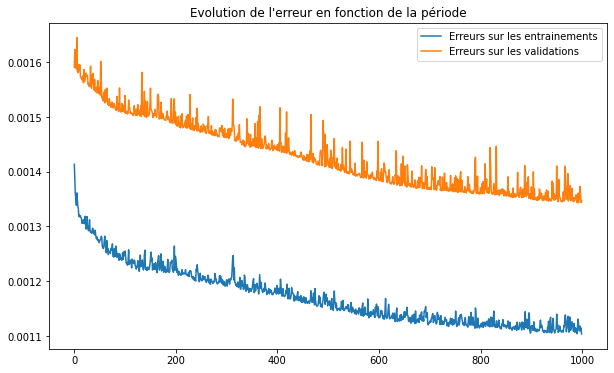

In [24]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**3. Prédictions single step**

In [25]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_etude.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_etude.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
if nb_input_bins == 1:
  pred_ent = model.predict(tf.expand_dims(x_train[:,:,0],2), verbose=1)
  pred_val = model.predict(tf.expand_dims(x_val[:,:,0],2), verbose=1)
else:
  pred_ent = model.predict(x_train, verbose=1)
  pred_val = model.predict(x_val, verbose=1)

12/12 [==============================] - 0s 2ms/step


In [26]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=serie_etude.index,y=serie_entrainement[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation:],y=serie_test[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation+taille_fenetre+horizon-1:],y=pred_val[:,taille_fenetre-1,0],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Prédictions multi-step ahead**

In [27]:
predictions = []

data_to_predict = x_val[0,:,0]
data_to_predict = tf.expand_dims(data_to_predict,1)
data_to_predict = tf.expand_dims(data_to_predict,0)

prediction = model.predict(data_to_predict)
predictions.append(prediction[0,taille_fenetre-1,0])

data_to_predict = x_val[1,0:taille_fenetre-1,0]
data_to_predict = np.insert(data_to_predict,taille_fenetre-1,predictions[0])

#for t in y_val_timing:
for i in range(1,200):
  data_to_predict = tf.expand_dims(data_to_predict,1)
  data_to_predict = tf.expand_dims(data_to_predict,0)
  prediction = model.predict(data_to_predict,1)
  predictions.append(prediction[0,taille_fenetre-1,0])

  data_to_predict = x_val[i+1,0:taille_fenetre-1,0]
  data_to_predict = np.insert(data_to_predict,taille_fenetre-1,predictions[i])


In [28]:
import plotly.graph_objects as go

fig = go.Figure()

n_max = len(predictions)

# Courbes originales
fig.add_trace(go.Scatter(x=serie_etude.index,y=serie_entrainement[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation:],y=serie_test[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation+taille_fenetre+horizon-1:temps_separation+taille_fenetre+horizon-1+n_max],y=predictions[0:n_max],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Création du modèle type Wavenet Multivarié - Apprentissage multivarié

**2. Construction du modèle**

In [35]:
def compute_receptive_field_(dilation_depth, nb_stacks):
    receptive_field = nb_stacks * (2 ** dilation_depth * 2) - (nb_stacks - 1)
    return receptive_field

nb_filters = 2
dim_filters = 2
nb_input_bins = 3
dilation_depth = 3
nb_stacks = 1
use_bias = False
res_l2 = 0
final_l2 = 0

fragment_length = compute_receptive_field_(dilation_depth, nb_stacks)
fragment_length

model = build_model(fragment_length, nb_filters, dim_filters, nb_input_bins, dilation_depth, nb_stacks, use_bias, res_l2, final_l2)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_part (InputLayer)         [(None, 16, 3)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 16)           0           input_part[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 16)           0           input_part[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 16)           0           input_part[0][0]                 
____________________________________________________________________________________________

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

OSError: ignored

In [36]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Entraine le modèle, avec une réduction des calculs du gradient
historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-6,periodes = 50, term="loss")],batch_size=batch_size)


# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-8,periodes = 10, term="val_My_MSE")])


Epoch 1/1000
16/16 [==============================] - 2s 28ms/step - loss: 1.0671 - mse: 1.0671 - My_MSE: 22.8910 - val_loss: 0.7252 - val_mse: 0.7252 - val_My_MSE: 17.5560

Epoch 00001: loss improved from inf to 0.99664, saving model to poids_train.hdf5
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.6753 - mse: 0.6753 - My_MSE: 16.7770 - val_loss: 0.4872 - val_mse: 0.4872 - val_My_MSE: 13.8409

Epoch 00002: loss improved from 0.99664 to 0.62800, saving model to poids_train.hdf5
Epoch 3/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.4715 - mse: 0.4715 - My_MSE: 13.5961 - val_loss: 0.3452 - val_mse: 0.3452 - val_My_MSE: 11.6256

Epoch 00003: loss improved from 0.62800 to 0.43973, saving model to poids_train.hdf5
Epoch 4/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.3390 - mse: 0.3390 - My_MSE: 11.5286 - val_loss: 0.2357 - val_mse: 0.2357 - val_My_MSE: 9.9163

Epoch 00004: loss improved from 0.43973 to 0.31278, savin

In [ ]:
model.load_weights("poids_train.hdf5")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

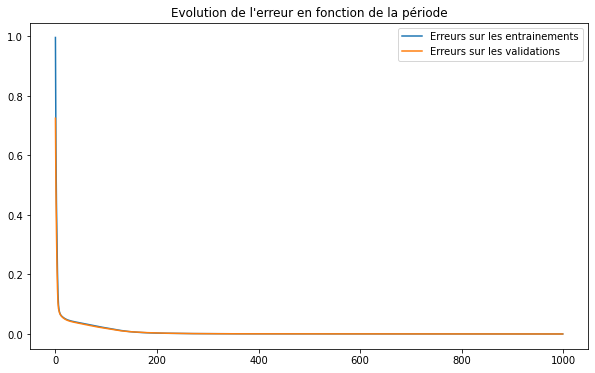

In [37]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**3. Prédictions single step**

In [38]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_etude.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_etude.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

12/12 [==============================] - 0s 2ms/step


In [39]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=serie_etude.index,y=serie_entrainement[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation:],y=serie_test[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation+taille_fenetre+horizon-1:],y=pred_val[:,taille_fenetre-1,0],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Prédictions multi-step ahead (Prédiction de Xt+1 avec Xt, Yt+1, Zt+1)**

In [54]:
predictions = []

data_to_predict = x_val[0,:,:]                          # [[X0,Y0,Z0],[X1,Y1,Z1], ... , [X15,Y15,Z15]] : (16,3)

data_to_predict = tf.expand_dims(data_to_predict,0)     # (1,16,3)
prediction = model.predict(data_to_predict)             # [[[X^1][X^2][X^3]...[X1^6]]] : (1,16,1)
predictions.append(prediction[0,taille_fenetre-1,0])    # [X^16] : (1,)

data_to_predict = x_val[1,0:taille_fenetre-1,:]         # [[X1,Y1,Z1],[X2,Y2,Z2], ... , [X15,Y15,Z15]] : (15,3)

data_to_predict = np.insert(data_to_predict,taille_fenetre-1,     # [[X1,Y1,Z1],[X2,Y2,Z2], ... , [X15,Y15,Z15], [X^16,Y16,Z16]] : (16,3)
                            [predictions[0],
                             x_val[1,taille_fenetre-1,1],
                             x_val[1,taille_fenetre-1,2]],axis=0)    


for i in range(1,300):
  data_to_predict = tf.expand_dims(data_to_predict,0)   # (16,3) => (1,16,3)
  prediction = model.predict(data_to_predict)           # [[[X^2][X^3][X^4]...[X^17]]] : (1,16,1)

  predictions.append(prediction[0,taille_fenetre-1,0])  # [X^17] : (1,)
  data_to_predict = x_val[i+1,0:taille_fenetre-1,:]     # [[X2,Y2,Z2],[X3,Y3,Z3], ... , [X16,Y16,Z16]] : (15,3)

  data_to_predict = np.insert(data_to_predict,taille_fenetre-1,       # [[X2,Y2,Z2],[X3,Y3,Z3], ... , [X16,Y16,Z16], [X^17,Y17,Z17]] : (16,3)
                            [predictions[i],
                             x_val[i+1,taille_fenetre-1,1],
                             x_val[i+1,taille_fenetre-1,2]],axis=0)

In [55]:
import plotly.graph_objects as go

fig = go.Figure()

n_max = len(predictions)

# Courbes originales
fig.add_trace(go.Scatter(x=serie_etude.index,y=serie_entrainement[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation:],y=serie_test[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation+taille_fenetre+horizon-1:temps_separation+taille_fenetre+horizon-1+n_max],y=predictions[0:n_max],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Prédictions multi-step ahead (Prédiction de Xt+1 avec Xt, Yt, Zt)**

In [59]:
predictions_2 = []

data_to_predict = x_val[0,:,:]                          # [[X0,Y0,Z0],[X1,Y1,Z1], ... , [X15,Y15,Z15]] : (16,3)

data_to_predict = tf.expand_dims(data_to_predict,0)     # (1,16,3)
prediction = model.predict(data_to_predict)             # [[[X^1][X^2][X^3]...[X1^6]]] : (1,16,1)
predictions_2.append(prediction[0,taille_fenetre-1,0])  # [X^16] : (1,)

data_to_predict = x_val[1,0:taille_fenetre-1,:]         # [[X1,Y1,Z1],[X2,Y2,Z2], ... , [X15,Y15,Z15]] : (15,3)

data_to_predict = np.insert(data_to_predict,taille_fenetre-1,     # [[X1,Y1,Z1],[X2,Y2,Z2], ... , [X15,Y15,Z15], [X^16,Y15,Z15]] : (16,3)
                            [predictions_2[0],
                             x_val[1,taille_fenetre-2,1],
                             x_val[1,taille_fenetre-2,2]],axis=0)    


for i in range(1,300):
  data_to_predict = tf.expand_dims(data_to_predict,0)   # (16,3) => (1,16,3)
  prediction = model.predict(data_to_predict)           # [[[X^2][X^3][X^4]...[X^17]]] : (1,16,1)

  predictions_2.append(prediction[0,taille_fenetre-1,0])  # [X^17] : (1,)
  data_to_predict = x_val[i+1,0:taille_fenetre-1,:]     # [[X2,Y2,Z2],[X3,Y3,Z3], ... , [X16,Y16,Z16]] : (15,3)

  data_to_predict = np.insert(data_to_predict,taille_fenetre-1,       # [[X2,Y2,Z2],[X3,Y3,Z3], ... , [X16,Y16,Z16], [X^17,Y16,Z16]] : (16,3)
                            [predictions_2[i],
                             x_val[i+1,taille_fenetre-2,1],
                             x_val[i+1,taille_fenetre-2,2]],axis=0)

In [60]:
import plotly.graph_objects as go

fig = go.Figure()

n_max = len(predictions_2)

# Courbes originales
fig.add_trace(go.Scatter(x=serie_etude.index,y=serie_entrainement[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation:],y=serie_test[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation+taille_fenetre+horizon-1:temps_separation+taille_fenetre+horizon-1+n_max],y=predictions_2[0:n_max],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()